In [165]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats

# Problem 1

## 1.A

In [166]:
data1 = pd.read_csv("problem1.csv")
mean = data1.mean()
var = data1.var()
skewness = data1.skew()
kurtosis = data1.kurt()
print("Mean: {}".format(mean["X"]))
print("Variance: {}".format(var["X"]))
print("Skewness: {}".format(skewness["X"]))
print("Kurtosis: {}".format(kurtosis["X"]))

Mean: 0.05019795790476916
Variance: 0.010332476407479588
Skewness: 0.1206257259522635
Kurtosis: 0.23006981317028652


## 1.B

<Axes: ylabel='Density'>

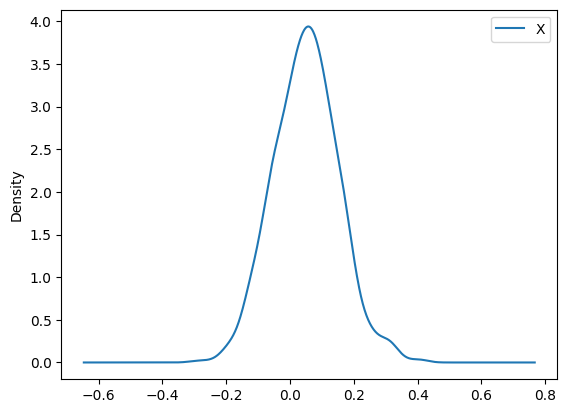

In [167]:
data1.plot(kind="density")

I would choose T-Distribution to model the data. It is because the excess kurtosis is positive, indicating a t-distribution.

## 1.C

In [168]:
# Fit model
mu_norm, sigma_norm = stats.norm.fit(data1)
df_t, mu_t, sigma_t = stats.t.fit(data1)
# Calculate AIC & BIC
ll_norm = np.sum(stats.norm.logpdf(data1, mu_norm, sigma_norm))
ll_t = np.sum(stats.t.logpdf(data1, df_t, mu_t, sigma_t))
aic_norm = 2 * 2 - 2 * ll_norm
aic_t = 2 * 3 - 2 * ll_t
bic_norm = 2 * len(data1) ** 0.5 - 2 * ll_norm
bic_t = 3 * len(data1) ** 0.5 - 2 * ll_t
df_ana = pd.DataFrame(index=["norm", "t"], columns=["log_likelyhood", "AIC", "BIC"])
df_ana.loc["norm"] = [ll_norm, aic_norm, bic_norm]
df_ana.loc["t"] = [ll_t, aic_t, bic_t]
df_ana

,log_likelyhood,AIC,BIC
norm,867.793364,-1731.586729,-1672.341176
t,868.709184,-1731.418369,-1642.550039


Since BIC of normal distribution is smaller, I disapprove my choice in 1.B and we should choose **normal distribution** to fit the data. 

# Problem 2

## 2.A

In [169]:
data2 = pd.read_csv("problem2.csv")


# Calculate covariance matrix
def cov_matrix(df: pd.DataFrame, skip_miss=True):
    """Calculate covariance matrix.

    Args:
        df (_type_): data
        skip_miss (bool, optional): If true, skipping missing, get all the rows which have values and calculate the covariance. If false, pairwise. For each cell, calculate the covariance. Defaults to True.
    """
    
    if skip_miss:
        return df.dropna().cov().values
    
    m = df.shape[1]
    result = np.full((m, m), np.nan)
    for i in range(0, m):
        for j in range(i, m):
            temp = df.iloc[:, [i, j]].copy().dropna()
            cov = float(temp.iloc[:, 0].cov(temp.iloc[:, 1]))
            result[i, j] = cov
            result[j, i] = cov
    return result

cov_matrix_pairwise = cov_matrix(data2, skip_miss=False)
print(cov_matrix_pairwise)

[[1.47048437 1.45421424 0.87726904 1.90322645 1.44436105]
 [1.45421424 1.25207795 0.53954816 1.62191837 1.23787697]
 [0.87726904 0.53954816 1.272425   1.17195897 1.091912  ]
 [1.90322645 1.62191837 1.17195897 1.81446921 1.58972858]
 [1.44436105 1.23787697 1.091912   1.58972858 1.39618646]]


## 2.B

In [170]:

eigens = np.linalg.eigvals(cov_matrix_pairwise)
print(eigens)

[ 6.78670573  0.83443367 -0.31024286  0.02797828 -0.13323183]


Since some eigenvalues for the pairwise covariance matrix are negative, the matrix is not positive semi-definite.

## 2.C

In [171]:
# Reference: 

def _getPs(A, W, threshold):
    W_sqrt = np.matrix(W ** 0.5)
    eigen_vals, eigen_vec = np.linalg.eig(W_sqrt * A * W_sqrt)
    Q = np.matrix(eigen_vec)
    max_diag = np.matrix(np.diag(np.maximum(eigen_vals, threshold)))
    A_plus =  Q*max_diag*Q.T
    return  W_sqrt.I * A_plus * W_sqrt.I

def _getPu(A, W):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearest_psd_higham(mat, threshold, n):
    m = mat.shape[0]
    d = np.sqrt(np.diag(mat))
    d_inv = np.diag(1 / d)
    mat_corr = d_inv @ mat @ d_inv
    W = np.identity(m) 
    # W is the matrix used for the norm (assumed to be Identity matrix here)
    # the algorithm should work for any diagonal W
    deltaS = 0
    Yk = mat_corr.copy()
    for i in range(0,n):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W, threshold)
        deltaS = Xk - Rk
        Y_next = _getPu(Xk, W)
        diff_norm = np.linalg.norm(Y_next - Yk, ord='fro')
        if diff_norm < threshold:
            break  # Stop early if the change is small
        Yk = Y_next  # Update for next iteration
    return np.diag(d) @ Yk @ np.diag(d)

def nearest_psd_rj(mat, threshold):
    m = mat.shape[0]
    d = np.sqrt(np.diag(mat))
    d_inv = np.diag(1 / d)
    mat_corr = d_inv @ mat @ d_inv
    eigen_vals, eigen_vector = np.linalg.eig(mat_corr)
    eigen_vals = np.maximum(eigen_vals, threshold)  # Set negative eigenvalues to zero
    t = np.zeros(shape = m)
    for i in range(0, m):
        sum_temp = 0
        for j in range(0, m):
            sum_temp += eigen_vector[i][j] ** 2 * eigen_vals[j]
        t[i] = 1.0 / sum_temp
    T_sqrt = np.diag(np.sqrt(t))
    eigen_vals_sqrt = np.sqrt(eigen_vals)
    B = T_sqrt @ eigen_vector @ eigen_vals_sqrt
    print(B)
    C_hat = np.outer(B, B.T)
    return np.diag(d) @ C_hat @ np.diag(d)

threshold = 1e-8
a = nearest_psd_higham(cov_matrix_pairwise, threshold, 100)
print("Nearest positive semi-definite matrix using Higham’s method: \n", a)
b = nearest_psd_rj(cov_matrix_pairwise, threshold)
print("Nearest positive semi-definite matrix using Rebenato and Jackel’s method: \n", b)


Nearest positive semi-definite matrix using Higham’s method: 
 [[1.47048437 1.33236075 0.88437762 1.62760182 1.3995556 ]
 [1.33236075 1.25207795 0.619028   1.4506041  1.21445034]
 [0.88437762 0.619028   1.272425   1.07684649 1.05965831]
 [1.62760182 1.4506041  1.07684649 1.81446921 1.57792823]
 [1.3995556  1.21445034 1.05965831 1.57792823 1.39618646]]
[1.18310245 1.2915669  0.0921008  1.11783799 0.76704583]
Nearest positive semi-definite matrix using Rebenato and Jackel’s method: 
 [[2.05828317 2.07340983 0.14905003 2.16026101 1.30030606]
 [2.07340983 2.08864766 0.15014543 2.17613712 1.30986222]
 [0.14905003 0.15014543 0.01079342 0.15643473 0.09416132]
 [2.16026101 2.17613712 0.15643473 2.26729135 1.36472985]
 [1.30030606 1.30986222 0.09416132 1.36472985 0.8214593 ]]


## 2.D

In [172]:
cov_matrix_overlapping = cov_matrix(data2)
print(cov_matrix_overlapping)

[[0.41860366 0.39405407 0.42445735 0.41638241 0.43428682]
 [0.39405407 0.39678563 0.40934344 0.3984012  0.42263077]
 [0.42445735 0.40934344 0.4413601  0.42844141 0.44895733]
 [0.41638241 0.3984012  0.42844141 0.43727358 0.44016735]
 [0.43428682 0.42263077 0.44895733 0.44016735 0.46627249]]


## 2.E

The covariance matrix using Higham’s method and the of Rebenato and Jackel are closer to the real covariance matrix than using the overlapping data. The covariances in matrices from 2.C tend to be overestimated (Higham’s method seems more accurate), while using overlapping data underestimates the covariances.

# Problem 3

## 3.A

In [173]:
data3 = pd.read_csv("problem3.csv")
# Calculate mean and covariance matrix
mu = data3.mean().values
print("Expected values:")
print(mu)
cov_matrix = data3.cov().values
print("Covariance matrix:")
print(cov_matrix)


Expected values:
[0.04600157 0.09991502]
Covariance matrix:
[[0.0101622  0.00492354]
 [0.00492354 0.02028441]]


The expected values and covariance matrix of the multivariable normal model are showed above.

## 3.B

### Method 1: Using the formula

$\bar{\mu}=\mu_2+\sigma_{12}\sigma_{11}^{-1}(a-\mu_1)$

$\bar{\sigma}=\sigma_{22}-\sigma_{12}\sigma_{11}^{-1}\sigma_{12}$

In [174]:
mu_con = mu[1] + cov_matrix[0][1] * (1 / cov_matrix[0][0]) * (0.6 - mu[0])
var_con  = cov_matrix[1][1] - cov_matrix[0][1] * cov_matrix[0][0] * cov_matrix[0][1]
print("mu:", mu_con)
print("sigma:", var_con)

mu: 0.3683249958609775
sigma: 0.020284159537142844


$X_2|X_1=0.6\sim N(0.3683, 0.0203)$

### Method 2: Simulation

In [175]:
# Calculate Cholesky root
L = np.linalg.cholesky(cov_matrix)
# Simulation
# WARNING: Large Sample Size!
size = 100000000
Z = np.random.randn(size, 2).T
X = (L @ Z).T + mu
threshold = 0.02
condition = np.abs(X[:, 0] - 0.6) < threshold
X_con = X[condition]
mu_con = X_con.mean()
sigma_con = X_con.var()
print("mu_simulation:", mu_con)
print("sigma_simulation", sigma_con)

mu_simulation: 0.5144932194016819
sigma_simulation 0.02939849837542517


## 3.C

The simulation proved that the distribution is correct. (Since qualified sample size is small, the result is different from calculated.) 

# Problem 4

## 4.A

In [176]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

MA1/MA2/MA3


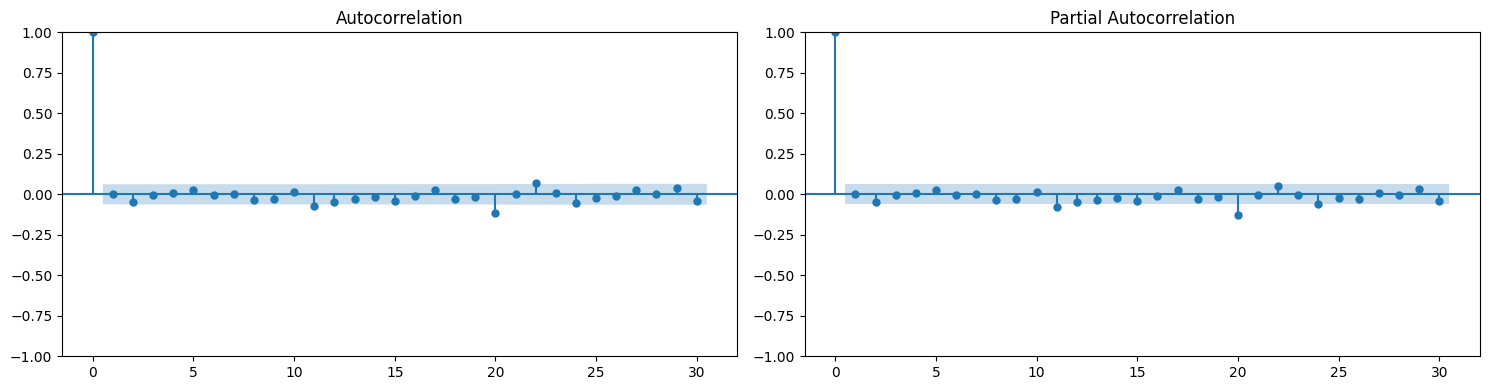

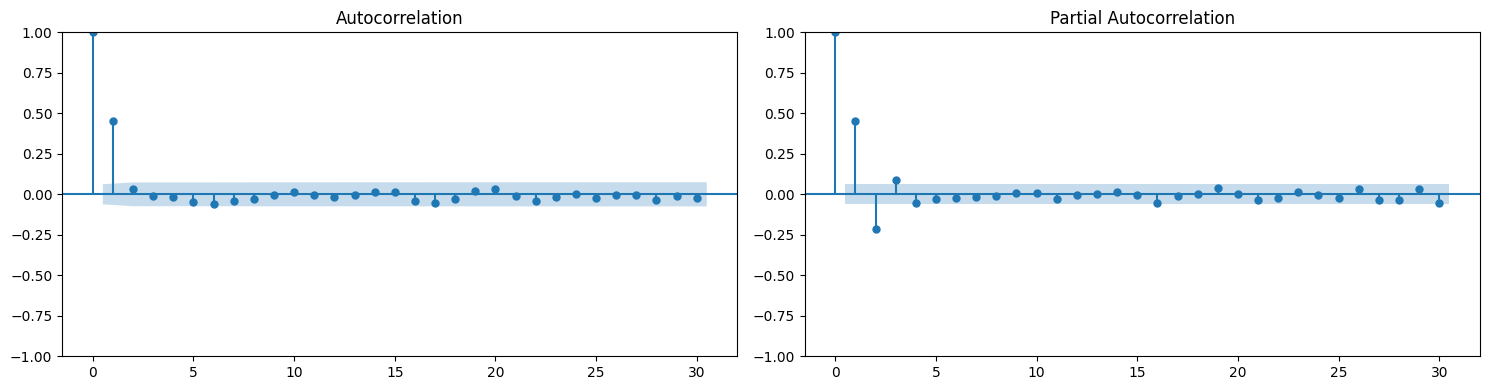

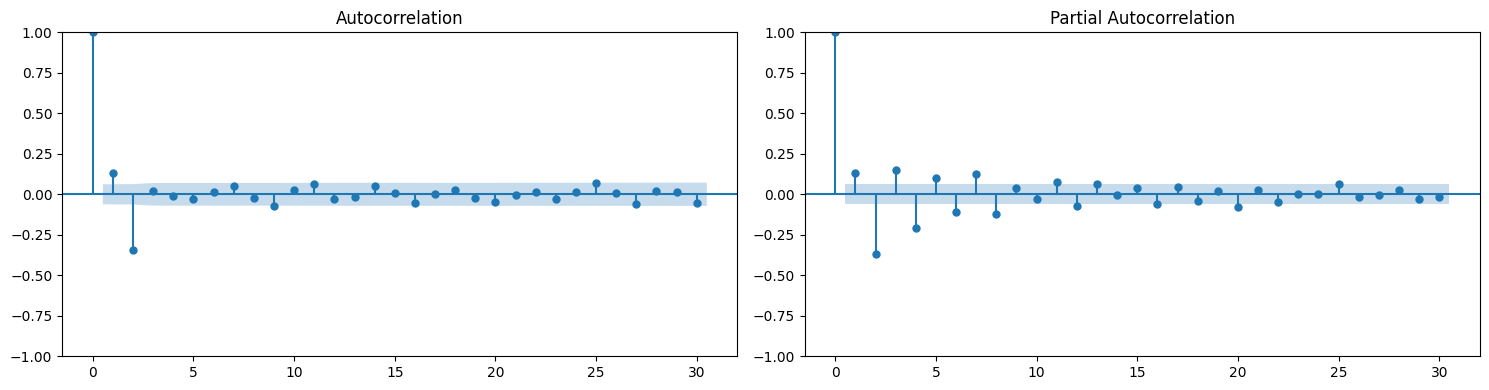

In [177]:
def tsplot(y, lags=None, figsize=(15, 4)):
    fig = plt.figure(figsize=figsize)
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
    plt.tight_layout()

print("MA1/MA2/MA3")
# MA(1)
ar = np.r_[1]
ma = np.r_[np.array([.65])]
ma1 = ArmaProcess(ar, ma)
y = ma1.generate_sample(1000)
tsplot(y)
# MA(2)
ma = np.r_[np.array([.65, .35])]
ma2 = ArmaProcess(ar, ma)
y = ma2.generate_sample(1000)
tsplot(y)
# MA(3)
ma = np.r_[np.array([.65, .35, -.4])]
ma3 = ArmaProcess(ar, ma)
y = ma3.generate_sample(1000)
tsplot(y)

For MA processes, ACF indicates the order and the sign of coefficients. The number of significant lags is the order. The signs of lags are the same as coefficients.

## 4.B

AR1/AR2/AR3


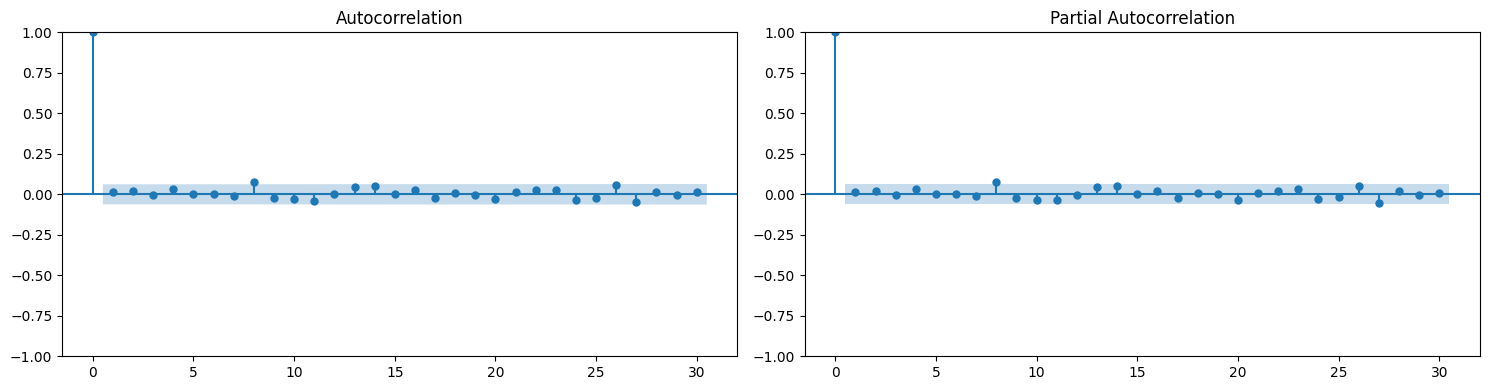

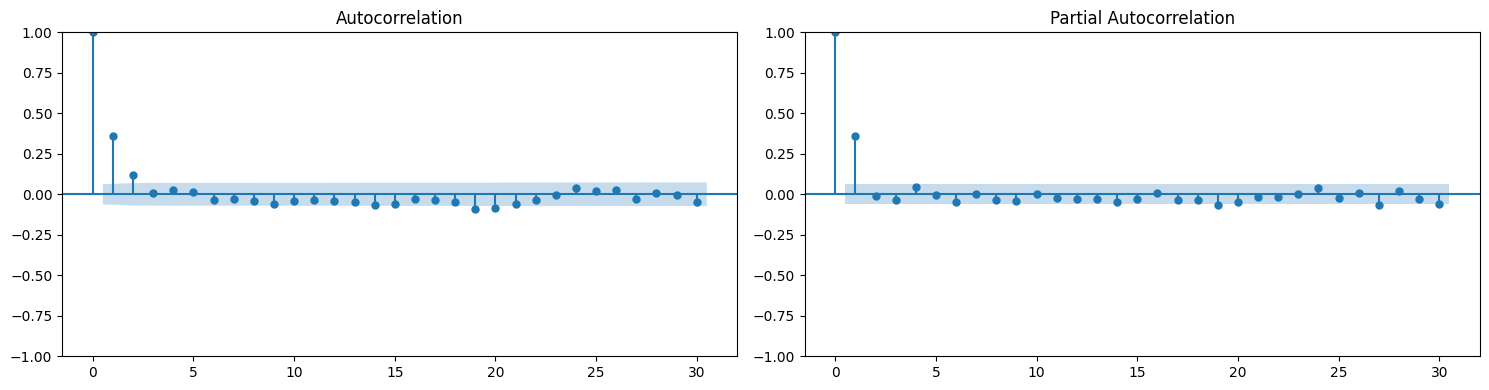

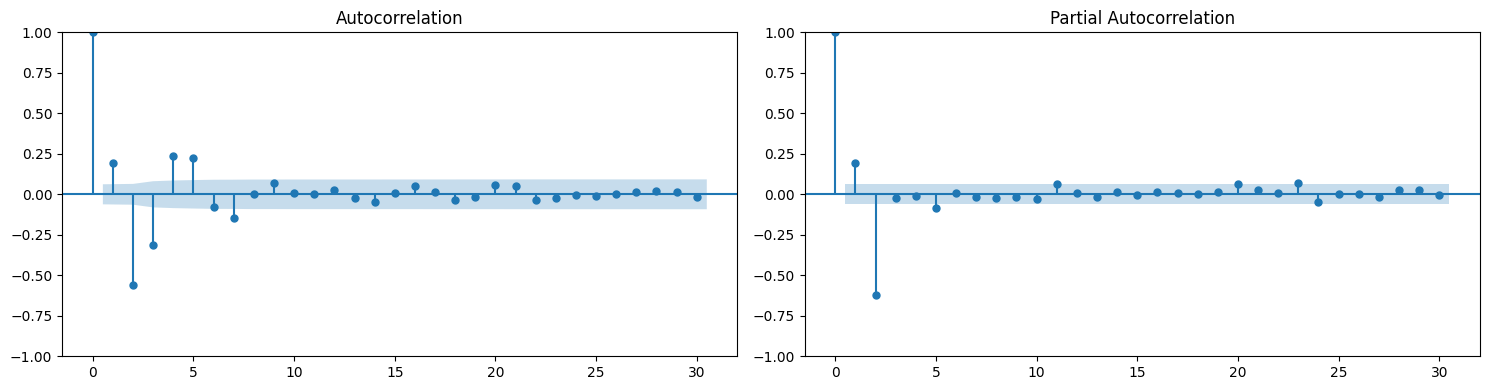

In [178]:
print("AR1/AR2/AR3")
# AR(1)
ma = np.r_[1]
ar = np.r_[np.array([.75])]
ar1 = ArmaProcess(ar, ma)
y = ar1.generate_sample(1000)
tsplot(y)
# AR(2)
ar = np.r_[np.array([.75, -.25])]
ar2 = ArmaProcess(ar, ma)
y = ar2.generate_sample(1000)
tsplot(y)
# AR(3)
ar = np.r_[np.array([.75, -.25, .5])]
ar3 = ArmaProcess(ar, ma)
y = ar3.generate_sample(1000)
tsplot(y)

For AR processes, PACF indicates the order and the sign of coefficients. The number of significant lags is the order. The signs of lags are the same as coefficients.

## 4.C

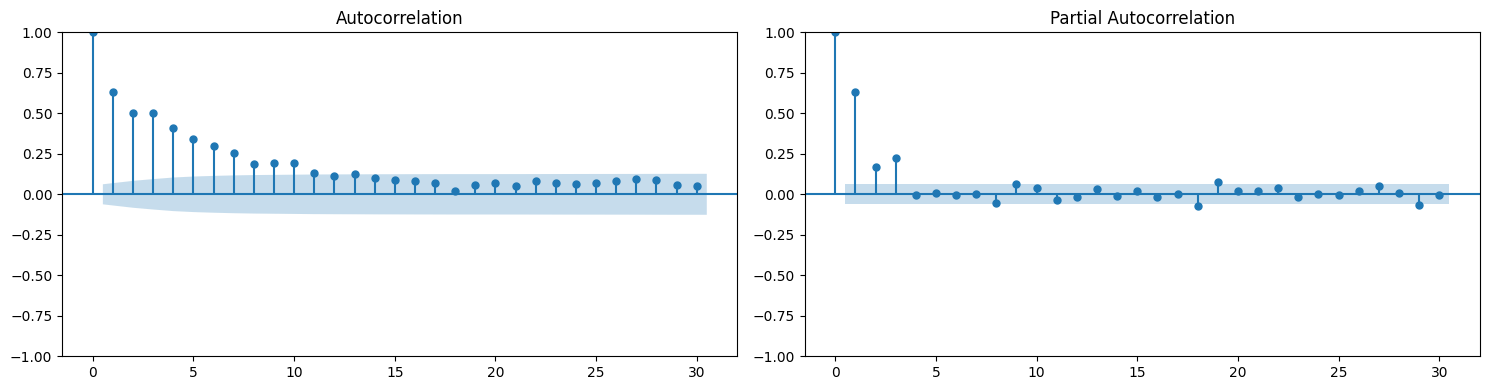

In [179]:
data4 = pd.read_csv("problem4.csv")
tsplot(data4)

I would use AR(4). Since four lags in PACF are significant, the order of the AR model might be 4.

## 4.D

In [180]:
models = {}
for p in range(5):
    for q in range(5):
        model = ARIMA(y, order=(p, 0, q)).fit()
        k = p + q + 1
        aicc = model.aic + (2 * k ** 2 + 2 * k) / (len(data4) - k - 1)
        models[(p, q)] = aicc
models = dict(sorted(models.items(), key=lambda x: x[1]))
print(models)
result = pd.DataFrame.from_dict(models, orient='index', columns=['AICc'])
result


/Users/xinkunkang/Documents/FinTech545-KK/Projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/xinkunkang/Documents/FinTech545-KK/Projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{(2, 3): np.float64(3472.973672501716), (3, 3): np.float64(3474.8371132938178), (2, 4): np.float64(3474.930890513694), (2, 0): np.float64(3475.5175608868103), (4, 3): np.float64(3476.6175013611564), (3, 4): np.float64(3476.795368356203), (2, 1): np.float64(3476.9091388523752), (3, 0): np.float64(3476.9329775024485), (3, 1): np.float64(3477.587933232605), (4, 4): np.float64(3478.6038200628304), (2, 2): np.float64(3478.6939438428576), (4, 0): np.float64(3478.875293320982), (3, 2): np.float64(3479.461543727294), (4, 1): np.float64(3479.506801204213), (4, 2): np.float64(3479.529972038485), (1, 4): np.float64(3511.080705334172), (0, 4): np.float64(3526.1186459783303), (1, 3): np.float64(3534.0830867127484), (0, 3): np.float64(3536.3276650028106), (1, 2): np.float64(3616.787769334701), (0, 2): np.float64(3659.2822173393943), (1, 1): np.float64(3784.309476569365), (0, 1): np.float64(3798.700179910024), (1, 0): np.float64(3958.6655207523613), (0, 0): np.float64(3995.2021842150966)}


,AICc
"(2, 3)",3472.973673
"(3, 3)",3474.837113
"(2, 4)",3474.930891
"(2, 0)",3475.517561
"(4, 3)",3476.617501
"(3, 4)",3476.795368
"(2, 1)",3476.909139
"(3, 0)",3476.932978
"(3, 1)",3477.587933
"(4, 4)",3478.603820


After comparing AICc of different models, **AR(2)** has the least AICc, so it is the best fit.

# Problem 5

## 5.A

In [181]:
data5 =pd.read_csv("DailyReturn.csv", index_col="Date")
l = .97
ewm_cov_matrix = data5.ewm(alpha=1-l, adjust=True).cov(pairwise=True).iloc[-len(data5.columns):]
ewm_cov_matrix

SPY      AAPL      NVDA      MSFT      AMZN      META  \
Date                                                                          
2025-01-03 SPY   0.000073  0.000055  0.000126  0.000082  0.000113  0.000082   
           AAPL  0.000055  0.000141  0.000041  0.000085  0.000082  0.000057   
           NVDA  0.000126  0.000041  0.000673  0.000135  0.000199  0.000189   
           MSFT  0.000082  0.000085  0.000135  0.000163  0.000176  0.000128   
           AMZN  0.000113  0.000082  0.000199  0.000176  0.000328  0.000190   
...                   ...       ...       ...       ...       ...       ...   
           KKR   0.000137  0.000042  0.000224  0.000107  0.000191  0.000121   
           MU    0.000150  0.000056  0.000309  0.000153  0.000175  0.000167   
           PLD   0.000060  0.000061  0.000014  0.000062  0.000057  0.000014   
           LRCX  0.000129  0.000085  0.000327  0.000154  0.000188  0.000232   
           EQIX  0.000053  0.000038  0.000050  0.000055  0.000072  0.000075   

                    GOOGL      AVGO      TSLA      GOOG  ...      SBUX  \
Date                                                     ...             
2025-01-03 SPY   0.000089  0.000179  0.000238  0.000090  ...  0.000041   
           AAPL  0.000072  0.000142  0.000176  0.000072  ...  0.000008   
           NVDA  0.000147  0.000227  0.000239  0.000150  ...  0.000038   
           MSFT  0.000124  0.000199  0.000283  0.000124  ...  0.000017   
           AMZN  0.000204  0.000300  0.000378  0.000202  ...  0.000020   
...                   ...       ...       ...       ...  ...       ...   
           KKR   0.000164  0.000280  0.000489  0.000166  ...  0.000089   
           MU    0.000169  0.000911  0.000487  0.000183  ...  0.000073   
           PLD   0.000026  0.000065  0.000122  0.000030  ...  0.000084   
           LRCX  0.000161  0.000592  0.000449  0.000165  ...  0.000073   
           EQIX  0.000052  0.000065  0.000156  0.000053  ...  0.000060   

                      MMC       MDT        CB       LMT       KKR        MU  \
Date                                                                          
2025-01-03 SPY   0.000031  0.000030  0.000028  0.000026  0.000137  0.000150   
           AAPL  0.000014  0.000008  0.000026  0.000003  0.000042  0.000056   
           NVDA  0.000012  0.000008 -0.000009  0.000028  0.000224  0.000309   
           MSFT  0.000026  0.000018  0.000024 -0.000015  0.000107  0.000153   
           AMZN  0.000021  0.000013  0.000015 -0.000008  0.000191  0.000175   
...                   ...       ...       ...       ...       ...       ...   
           KKR   0.000070  0.000059  0.000071  0.000065  0.000425  0.000257   
           MU   -0.000004  0.000026 -0.000007  0.000036  0.000257  0.001497   
           PLD   0.000045  0.000059  0.000033  0.000029  0.000066  0.000158   
           LRCX  0.000006  0.000017  0.000009 -0.000018  0.000196  0.000717   
           EQIX  0.000046  0.000026  0.000030  0.000006  0.000100  0.000087   

                      PLD      LRCX      EQIX  
Date                                           
2025-01-03 SPY   0.000060  0.000129  0.000053  
           AAPL  0.000061  0.000085  0.000038  
           NVDA  0.000014  0.000327  0.000050  
           MSFT  0.000062  0.000154  0.000055  
           AMZN  0.000057  0.000188  0.000072  
...                   ...       ...       ...  
           KKR   0.000066  0.000196  0.000100  
           MU    0.000158  0.000717  0.000087  
           PLD   0.000254  0.000086  0.000089  
           LRCX  0.000086  0.000750  0.000075  
           EQIX  0.000089  0.000075  0.000156  

[100 rows x 100 columns]

## 5.B

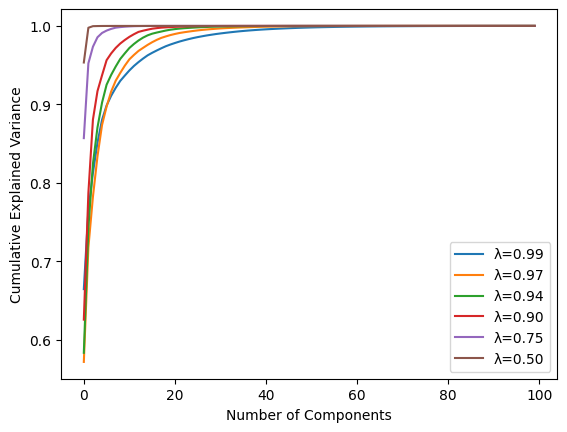

In [182]:
from sklearn.decomposition import PCA

lambda_values = [.99, .97, .94, .90, .75, .50]
for l in lambda_values:
    cov_matrix = data5.ewm(alpha=1-l, adjust=True).cov(pairwise=True).iloc[-len(data5.columns):]
    pca = PCA()
    pca.fit(cov_matrix)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(cumulative_variance, label=f'λ={l:.2f}')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()

## 5.C

When $\lambda$ is greater, more weight is given to recent observations, and more components are needed to explain the variance. 

# Problem 6

## 6.A

In [183]:
import statsmodels.stats as st

In [203]:
data6 = pd.read_csv("problem6.csv").values
cov_mat_psd = nearest_psd_higham(data6, 1e-8, 100)
L = np.linalg.cholesky(cov_mat_psd)
# Cholesky
size = 10000
Z = np.random.randn(size, cov_mat_psd.shape[0]).T

sim_cholesky = (L @ Z).T
print(sim_cholesky)


[[-0.0276929   0.09103946 -0.01382116 ...  0.03641649  0.00689754
  -0.00024638]
 [ 0.08891714 -0.01107034  0.22684868 ...  0.06326584  0.03342219
  -0.00931384]
 [ 0.07236268 -0.00758801  0.01514524 ...  0.04914396 -0.02217009
   0.00520904]
 ...
 [-0.04575931  0.00175756 -0.04145118 ...  0.03697378 -0.10085683
  -0.02584803]
 [ 0.00307359  0.03769386 -0.03142074 ...  0.09109808  0.05374363
   0.03720339]
 [ 0.16324299  0.05059093 -0.00189914 ...  0.09393726 -0.01270218
  -0.00877576]]


## 6.B

In [204]:
# PCA
pca = PCA()
pca.fit(data6)
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cum_var >= 0.75) + 1 
pca = PCA(n_components=n_components, svd_solver='full')
pca.fit(data6)
sim_pca = np.random.randn(size, n_components) @ np.diag(np.sqrt(pca.explained_variance_)) @ pca.components_
print(sim_pca)

[[ 3.52723499e-04 -2.11627454e-04 -4.08740005e-04 ... -9.22385424e-05
   4.06436950e-04 -1.89788724e-05]
 [ 1.98589068e-04  2.48737939e-04 -6.40245952e-04 ... -4.62718045e-04
   3.93091555e-04  8.10802356e-05]
 [-2.33628878e-04 -3.44454372e-04 -1.13269788e-04 ... -1.58222826e-04
  -5.75297577e-04 -8.06520567e-05]
 ...
 [-4.93025440e-04 -6.42649869e-05 -4.03812749e-04 ...  2.22781431e-04
  -4.77609867e-04  2.56780181e-05]
 [-2.44695149e-04 -9.05137133e-05  3.15281422e-04 ...  8.48610403e-05
   6.42719313e-04  2.70322706e-05]
 [ 9.10418641e-04  1.22797224e-04 -4.03355171e-04 ... -2.81364735e-04
   7.21149957e-04  7.45835008e-05]]


## 6.C

In [205]:
cov_cholesky = np.cov(sim_cholesky.T)
cov_pca = np.cov(sim_pca.T)

norm_original = np.linalg.norm(data6, 'fro')
norm_cholesky = np.linalg.norm(cov_cholesky, 'fro')
norm_pca = np.linalg.norm(cov_pca, 'fro')
print("Original: ", norm_original)
print("Cholesky: ", norm_cholesky)
print("PCA: ", norm_pca)

Original:  0.26030588695130713
Cholesky:  0.2613384682506173
PCA:  2.0524475387529616e-05


The Frobenius norm of simulation using Cholesky is close to the original value. PCA is much less compared to the other two.

## 6.D

In [206]:
eigvals_original = np.linalg.eigvals(data6)
eigvals_cholesky = np.linalg.eigvals(cov_cholesky)
eigvals_pca = np.linalg.eigvals(cov_pca)

K_original = np.cumsum(np.sort(eigvals_original)[::-1]) / np.sum(eigvals_original)
K_cholesky = np.cumsum(np.sort(eigvals_cholesky)[::-1]) / np.sum(eigvals_cholesky)
K_pca = np.cumsum(np.sort(eigvals_pca)[::-1]) / np.sum(eigvals_pca)
print("Original: \n", K_original)
print("Cholesky: \n", K_cholesky)
print("PCA: \n", K_pca)

Original: 
 [0.02761939 0.05418435 0.07962796 0.10481583 0.12919237 0.15320067
 0.17563346 0.19767436 0.21917739 0.24025578 0.26091835 0.28112831
 0.30123289 0.32109985 0.34021781 0.35891413 0.3771812  0.39525532
 0.41286727 0.43011022 0.44715547 0.4636013  0.47996073 0.49571076
 0.51142897 0.52652034 0.54106345 0.55554076 0.56978505 0.58370873
 0.59734631 0.61072527 0.62367645 0.63636435 0.648597   0.66077886
 0.67279265 0.68464285 0.69600906 0.70713825 0.71790311 0.72858805
 0.73884301 0.74903246 0.75901601 0.76889913 0.77836579 0.78742257
 0.79639387 0.80526487 0.813869   0.82233376 0.83046601 0.83850267
 0.84614709 0.85362782 0.86074911 0.86759656 0.87427735 0.88081977
 0.88713297 0.89334538 0.89950361 0.90534239 0.91096358 0.91654004
 0.9217448  0.92677263 0.93168606 0.93636474 0.94096476 0.94540556
 0.94973381 0.95379628 0.95769382 0.96134215 0.96465242 0.96784099
 0.97087969 0.97374815 0.97655565 0.97918366 0.98165612 0.98400844
 0.98625171 0.98814044 0.98994853 0.99164101 0.993

The cumulative variance explained by each eigenvalu of the PCA simulated matrix is greater, while Cholesky simulated matrix is close to the original matrix.

## 6.E

Cholesky takes 1.7s while PCA takes 0.1s. PCA is much faster.

## 6.F

Cholesky works better for a full rank system and is more accurate. PCA is more efficient since it reduces size of the problem. If Eigenvalues are 0, they are removed from the matrix. Considering a model with many variables, PCA will be more efficient for modeling.